# Pong Policy Training Baseline with RLlib

This notebook implements a baseline policy training pipeline using Ray RLlib, training directly on visual observations without any encoder. This serves as a comparison baseline for the V-JEPA2 and RSSM approaches.

## Environment Notes

- **Google Colab**: keep the install cell and default config (2 CPUs, 1 GPU)
- **Local Apple Silicon (M1/M2)**: use the optimized configuration below (multi-core CPU, optional MPS acceleration)
- Adjust the configuration variables if you run on a different machine


In [65]:
# Install dependencies for Google Colab
# Note: Colab comes with gymnasium, but we need ray[rllib] and ale-py
%pip install -q "ray[rllib]" "gymnasium[atari]" ale-py

print("Dependencies installed successfully!")
print("Note: Make sure you're using a GPU runtime (Runtime > Change runtime type > GPU) for faster training")


Note: you may need to restart the kernel to use updated packages.
Dependencies installed successfully!
Note: Make sure you're using a GPU runtime (Runtime > Change runtime type > GPU) for faster training


In [ ]:
import os
import numpy as np
import gymnasium as gym
import ale_py
from gymnasium import spaces
import matplotlib.pyplot as plt
from pathlib import Path

# Register ALE environments
gym.register_envs(ale_py)

# Configuration
GAME_ID = os.environ.get("ATARI_GAME", "PongNoFrameskip-v4")
NUM_TRAIN_ITERATIONS = int(os.environ.get("NUM_TRAIN_ITERATIONS", "400"))
EVAL_EPISODES = int(os.environ.get("NUM_EVAL_EPISODES", "5"))
PONG_SEEDS = [0, 1, 2, 3, 42]
MAX_EPISODE_STEPS = int(os.environ.get("MAX_EPISODE_STEPS", "1200"))
USE_MINIMAL_ACTIONS = bool(int(os.environ.get("PONG_MINIMAL_ACTIONS", "1")))

print(f"Game: {GAME_ID}")
print(f"Training iterations: {NUM_TRAIN_ITERATIONS}")
print(f"Evaluation episodes: {EVAL_EPISODES}")
print(f"Seed subset: {PONG_SEEDS}")
print(f"Episode step cap: {MAX_EPISODE_STEPS}")
print(f"Use minimal action set: {USE_MINIMAL_ACTIONS}")


Game: PongNoFrameskip-v4
Training iterations: 400
Evaluation episodes: 5
Seed subset: [0, 1, 2, 3, 42]
Episode step cap: 800
Use minimal action set: True


## Environment Setup

Create the Pong environment with standard preprocessing (resize to 84x84, normalize).


In [ ]:
def transform_obs(obs):
    """Transform observation to (C, H, W) format and normalize to [0, 1]."""
    obs_t = np.transpose(obs, (2, 0, 1)).astype(np.float32) / 255.0
    return obs_t

class MinimalPongActions(gym.ActionWrapper):
    ACTION_SET = [0, 2, 3]  # noop, up, down

    def __init__(self, env):
        super().__init__(env)
        self._action_set = MinimalPongActions.ACTION_SET
        self.action_space = spaces.Discrete(len(self._action_set))

    def action(self, act):
        return self._action_set[act]

print(f"Minimal Pong action set (if enabled): {MinimalPongActions.ACTION_SET}")

# Create environment with wrappers for quick sanity check
env = gym.make(GAME_ID)
if USE_MINIMAL_ACTIONS:
    env = MinimalPongActions(env)
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.TimeLimit(env, max_episode_steps=MAX_EPISODE_STEPS)

new_obs_space = spaces.Box(low=0.0, high=1.0, shape=(3, 84, 84), dtype=np.float32)

env = gym.wrappers.TransformObservation(
    env,
    func=transform_obs,
    observation_space=new_obs_space,
)

# Test environment
obs, info = env.reset(seed=PONG_SEEDS[0])
assert obs.shape == (3, 84, 84), f"Expected (3, 84, 84), got {obs.shape}"
print(f"Environment initialized successfully")
print(f"Observation shape: {obs.shape}")
print(f"Action space: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")


Environment initialized successfully
Observation shape: (3, 84, 84)
Action space: Discrete(3)
Number of actions: 3


A.L.E: Arcade Learning Environment (version 0.11.0+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /Users/lavan/miniconda3/envs/rl-pong/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1085872936
Game console created:
  ROM file:  /Users/lavan/miniconda3/envs/rl-pong/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -617818137


## RLlib Training Setup

Configure Ray RLlib to train a policy using PPO (Proximal Policy Optimization), which works well for Atari games.


In [68]:
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPOConfig

# Check available accelerators (CUDA or Apple MPS)
import torch
if torch.cuda.is_available():
    accelerator = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    accelerator = "mps"
else:
    accelerator = "cpu"

print(f"Detected accelerator: {accelerator}")
has_cuda = accelerator == "cuda"
has_mps = accelerator == "mps"

# Initialize Ray based on local resources
available_cpus = max(2, os.cpu_count() or 2)
print(f"Using up to {available_cpus} CPU cores for Ray")

if not ray.is_initialized():
    ray.init(
        ignore_reinit_error=True,
        num_cpus=available_cpus,
        num_gpus=1 if has_cuda else 0,
        object_store_memory=2_000_000_000,  # 2GB object store (macOS recommended limit)
    )
    print("Ray initialized")
else:
    print("Ray already initialized")



Detected accelerator: mps
Using up to 10 CPU cores for Ray
Ray already initialized


In [ ]:
def make_eval_env(seed=None):
    env = gym.make(GAME_ID)
    if USE_MINIMAL_ACTIONS:
        env = MinimalPongActions(env)
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.TimeLimit(env, max_episode_steps=MAX_EPISODE_STEPS)
    if seed is not None:
        env.reset(seed=int(seed))
        env.action_space.seed(int(seed))
    env = gym.wrappers.TransformObservation(
        env,
        func=transform_obs,
        observation_space=new_obs_space,
    )
    return env


In [69]:
# Create a function to register and return the environment
def env_creator(env_config):
    """Create and return the Pong environment."""
    import gymnasium as gym
    import ale_py
    from gymnasium import spaces

    gym.register_envs(ale_py)

    env = gym.make(GAME_ID)
    if USE_MINIMAL_ACTIONS:
        env = MinimalPongActions(env)
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.TimeLimit(env, max_episode_steps=MAX_EPISODE_STEPS)

    # Deterministic seed subset for faster experiments
    seed_list = env_config.get("seed_list", PONG_SEEDS)
    worker_idx = getattr(env_config, "worker_index", 0)
    vector_idx = getattr(env_config, "vector_index", 0)
    seed = seed_list[(worker_idx + vector_idx) % len(seed_list)]
    env.reset(seed=int(seed))
    env.action_space.seed(int(seed))

    def transform_obs(obs):
        obs_t = np.transpose(obs, (2, 0, 1)).astype(np.float32) / 255.0
        return obs_t

    new_obs_space = spaces.Box(low=0.0, high=1.0, shape=(3, 84, 84), dtype=np.float32)
    env = gym.wrappers.TransformObservation(
        env,
        func=transform_obs,
        observation_space=new_obs_space,
    )

    return env

# Register the environment with seed list
tune.register_env(
    "pong_env",
    lambda config: env_creator({**config, "seed_list": PONG_SEEDS}),
)
print("Environment registered with RLlib")


Environment registered with RLlib


In [70]:
# Configure PPO algorithm
# Local-friendly defaults: leverage multi-core CPU + optional GPU/MPS
num_env_runners = int(os.environ.get("NUM_ENV_RUNNERS", "1"))
num_envs_per_env_runner = int(os.environ.get("NUM_ENVS_PER_RUNNER", "2"))
train_batch_size = int(os.environ.get("TRAIN_BATCH_SIZE", "2000"))
use_gpu = has_cuda  # RLlib only counts CUDA as GPU; MPS is handled within PyTorch

# Local defaults (can be overridden via env vars)
num_env_runners = 4
num_envs_per_env_runner = 2
train_batch_size = 2000
num_epochs = 6

# Guard: cap env runners if requested processes exceed CPU cores
requested_env_processes = num_env_runners * num_envs_per_env_runner
max_env_processes = max(1, available_cpus - 2)  # leave headroom for learner/driver
if requested_env_processes > max_env_processes:
    print(f"⚠️ Requested {requested_env_processes} env processes but only {available_cpus} CPUs available (reserving 2 for learner/driver).")
    num_env_runners = max(1, max_env_processes // num_envs_per_env_runner)
    requested_env_processes = num_env_runners * num_envs_per_env_runner
    print(f"  Capping num_env_runners to {num_env_runners} (total env processes = {requested_env_processes}).")

config = (
    PPOConfig()
    .environment("pong_env")
    .framework("torch")
    .training(
        lr=3e-4,
        train_batch_size=train_batch_size,
        num_epochs=num_epochs,
        gamma=0.99,
        lambda_=0.95,
        clip_param=0.2,
        entropy_coeff=0.01,
        vf_loss_coeff=0.5,
    )
    .resources(num_gpus=0)
    .env_runners(
        num_env_runners=num_env_runners,
        num_envs_per_env_runner=num_envs_per_env_runner,
        num_cpus_per_env_runner=1,
        rollout_fragment_length="auto",
        batch_mode="truncate_episodes",
    )
    .evaluation(evaluation_interval=None)
)

print("PPO configuration (local-optimized):")
print(f"  Learning rate: {config.lr}")
print(f"  Training batch size: {config.train_batch_size}")
print(f"  Number of epochs: {config.num_epochs}")
print(f"  Number of env runners: {config.num_env_runners}")
print(f"  Env per runner: {num_envs_per_env_runner}")
print(f"  Total env processes: {config.num_env_runners * num_envs_per_env_runner}")
print(f"  Evaluation env runners: {config.evaluation_num_env_runners}")
print(f"  CUDA available: {use_gpu}")
print(f"  MPS available: {has_mps}")
print(f"  Gamma (discount): {config.gamma}")
print("  Note: Minibatch size is auto-calculated by RLlib")
print("  Note: Evaluation disabled during training for speed")


PPO configuration (local-optimized):
  Learning rate: 0.0003
  Training batch size: 2000
  Number of epochs: 6
  Number of env runners: 4
  Env per runner: 2
  Total env processes: 8
  Evaluation env runners: 0
  CUDA available: False
  MPS available: True
  Gamma (discount): 0.99
  Note: Minibatch size is auto-calculated by RLlib
  Note: Evaluation disabled during training for speed


## Diagnostics

Check Ray cluster status and algorithm readiness before training.


In [71]:
# Check Ray cluster status
import ray
print("Ray cluster status:")
cluster_resources = {}
available_resources = {}
try:
    cluster_resources = ray.cluster_resources()
    available_resources = ray.available_resources()
    print(f"  Total CPUs: {cluster_resources.get('CPU', 0)}")
    print(f"  Available CPUs: {available_resources.get('CPU', 0)}")
    print(f"  Total GPUs: {cluster_resources.get('GPU', 0)}")
    print(f"  Available GPUs: {available_resources.get('GPU', 0)}")
    used_cpus = cluster_resources.get('CPU', 0) - available_resources.get('CPU', 0)
    print(f"  Used CPUs: {used_cpus:.1f}")
except Exception as e:
    print(f"  Could not get cluster resources: {e}")

print("\nAlgorithm configuration check:")
try:
    num_train_cpus = config.num_env_runners * getattr(config, 'num_cpus_per_env_runner', 1)
    num_eval_cpus = config.evaluation_num_env_runners * getattr(config, 'num_cpus_per_env_runner', 1)
    total_required = num_train_cpus + num_eval_cpus
    print(f"  Required CPUs (training): {num_train_cpus}")
    print(f"  Required CPUs (evaluation): {num_eval_cpus}")
    print(f"  Total required: {total_required}")
    
    if cluster_resources:
        available_cpus = cluster_resources.get('CPU', 0)
        if total_required > available_cpus:
            print(f"  ⚠️  WARNING: Required CPUs ({total_required}) > Available CPUs ({available_cpus})")
            print(f"     This may cause training to hang. Consider reducing num_env_runners or setting evaluation_num_env_runners=0")
        else:
            print(f"  ✓ Resource requirements are within available resources")
    else:
        print(f"  (Could not verify against available resources)")
except Exception as e:
    print(f"  Could not check configuration: {e}")
    print(f"  Config attributes: num_env_runners={config.num_env_runners}, evaluation_num_env_runners={config.evaluation_num_env_runners}")


Ray cluster status:
  Total CPUs: 10.0
  Available CPUs: 2.0
  Total GPUs: 0
  Available GPUs: 0
  Used CPUs: 8.0

Algorithm configuration check:
  Required CPUs (training): 4
  Required CPUs (evaluation): 0
  Total required: 4
  ✓ Resource requirements are within available resources


## Build Algorithm

**Expected time: 1-3 minutes**

If this takes longer than 5 minutes, it may be stuck. Check:
1. Ray cluster status (diagnostics cell above)
2. No CPU resource warnings
3. If stuck, restart Ray and rebuild


## Training

Train the policy using RLlib's PPO algorithm.


In [72]:
from ray.rllib.algorithms.ppo import PPO
import time

# Build the algorithm (using new API method)
print("Building algorithm (this may take 1-3 minutes on first run)...")
print("Components being initialized:")
print("  - Neural network models")
print("  - Environment runners")
print("  - Learner group")
print("  - ALE environment (Pong ROM)")
print()

build_start = time.time()
try:
    algo = config.build_algo()
    build_time = time.time() - build_start
    print(f"\n✓ Algorithm built successfully in {build_time:.1f} seconds ({build_time/60:.1f} minutes)")
except Exception as e:
    build_time = time.time() - build_start
    print(f"\n✗ Algorithm build failed after {build_time:.1f} seconds")
    print(f"Error: {e}")
    raise

# Access the model - new API stack uses modules differently
try:
    # Try new API stack access
    if hasattr(algo, 'learner_group'):
        module = algo.learner_group.get_module()
        print(f"Policy module type: {type(module)}")
    elif hasattr(algo, 'get_policy'):
        # Old API stack
        policy = algo.get_policy()
        print(f"Policy network: {policy.model}")
    else:
        print("Algorithm built, but model access method not found")
        print(f"Algorithm type: {type(algo)}")
        print(f"Available attributes: {[attr for attr in dir(algo) if not attr.startswith('_')]}")
except Exception as e:
    print(f"Note: Could not access model directly: {e}")
    print("Algorithm is ready for training")


Building algorithm (this may take 1-3 minutes on first run)...
Components being initialized:
  - Neural network models
  - Environment runners
  - Learner group
  - ALE environment (Pong ROM)



(SingleAgentEnvRunner pid=85596) A.L.E: Arcade Learning Environment (version 0.11.0+unknown)
(SingleAgentEnvRunner pid=85596) [Powered by Stella]
(SingleAgentEnvRunner pid=85596) Game console created:
(SingleAgentEnvRunner pid=85596)   ROM file:  /Users/lavan/miniconda3/envs/rl-pong/lib/python3.11/site-packages/ale_py/roms/pong.bin
(SingleAgentEnvRunner pid=85596)   Cart Name: Video Olympics (1978) (Atari)
(SingleAgentEnvRunner pid=85596)   Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
(SingleAgentEnvRunner pid=85596)   Display Format:  AUTO-DETECT ==> NTSC
(SingleAgentEnvRunner pid=85596)   ROM Size:        2048
(SingleAgentEnvRunner pid=85596)   Bankswitch Type: AUTO-DETECT ==> 2K
(SingleAgentEnvRunner pid=85596) 
(SingleAgentEnvRunner pid=85596) Running ROM file...
(SingleAgentEnvRunner pid=85596) Random seed is 682205864
(SingleAgentEnvRunner pid=85596) Game console created:
(SingleAgentEnvRunner pid=85596)   ROM file:  /Users/lavan/miniconda3/envs/rl-pong/lib/python3.11/site-package


✓ Algorithm built successfully in 26.9 seconds (0.4 minutes)
Note: Could not access model directly: 'LearnerGroup' object has no attribute 'get_module'
Algorithm is ready for training


In [73]:
# Training loop
training_history = {
    "episode_reward_mean": [],
    "episode_reward_min": [],
    "episode_reward_max": [],
    "episode_len_mean": [],
}

print(f"Starting training for {NUM_TRAIN_ITERATIONS} iterations...")
print("=" * 60)
print("Note: First iteration may take longer to initialize environments")
print("=" * 60)

import time
start_time = time.time()

for i in range(NUM_TRAIN_ITERATIONS):
    iteration_start = time.time()
    
    # Train for one iteration
    try:
        result = algo.train()
    except Exception as e:
        print(f"\nERROR at iteration {i+1}: {e}")
        print("Training failed. Check resource constraints and Ray status.")
        break
    
    # Diagnostic check on first iteration: print all available metrics
    if i == 0:
        print("\nFirst iteration diagnostics:")
        print(f"  Result type: {type(result)}")
        print(f"  Result keys (first 20): {list(result.keys())[:20]}")
        
        # Check for environment runner metrics (new API - note: plural "env_runners")
        if "env_runners" in result:
            env_metrics = result["env_runners"]
            print(f"  Env runners metrics type: {type(env_metrics)}")
            if isinstance(env_metrics, dict):
                print(f"  Env runners keys: {list(env_metrics.keys())[:20]}")
                # Print some values
                for k in list(env_metrics.keys())[:10]:
                    print(f"    {k}: {env_metrics[k]}")
        elif "env_runner" in result:
            env_metrics = result["env_runner"]
            print(f"  Env runner (singular) metrics type: {type(env_metrics)}")
            if isinstance(env_metrics, dict):
                print(f"  Env runner keys: {list(env_metrics.keys())[:15]}")
        
        # Check for learner metrics
        if "learners" in result:
            learner_metrics = result["learners"]
            print(f"  Learners metrics keys: {list(learner_metrics.keys())[:15] if isinstance(learner_metrics, dict) else 'N/A'}")
        
        # Look for episode metrics in different places
        print("\n  Searching for episode/reward metrics:")
        for key in result.keys():
            if "episode" in key.lower() or "reward" in key.lower():
                val = result[key]
                print(f"    {key}: {val}")
        
        # Check env_runners dict for episode metrics
        if "env_runners" in result and isinstance(result["env_runners"], dict):
            print("\n  env_runners metrics:")
            for key in result["env_runners"].keys():
                if "episode" in key.lower() or "reward" in key.lower() or "step" in key.lower():
                    val = result["env_runners"][key]
                    print(f"    {key}: {val}")
            
            # Also check num_env_steps_sampled to see if steps are being collected
            if "num_env_steps_sampled" in result.get("env_runners", {}):
                print(f"\n  Total steps sampled: {result['env_runners']['num_env_steps_sampled']}")
        print()
    
    # Store metrics - new RLlib API uses different key names
    # In env_runners: episode_return_* (not episode_reward_*)
    # Also check agent_episode_return_mean for agent-specific rewards
    env_runners_metrics = result.get("env_runners", {})
    env_runner_metrics = result.get("env_runner", {})  # Also check singular for compatibility
    
    # Try env_runners first (new API), then env_runner, then top-level
    if isinstance(env_runners_metrics, dict) and len(env_runners_metrics) > 0:
        # New API uses "episode_return" not "episode_reward"
        episode_reward_mean = env_runners_metrics.get("episode_return_mean",
                                                      env_runners_metrics.get("episode_reward_mean",
                                                      result.get("episode_return_mean",
                                                                 result.get("episode_reward_mean", 0))))
        episode_reward_min = env_runners_metrics.get("episode_return_min",
                                                     env_runners_metrics.get("episode_reward_min",
                                                     result.get("episode_return_min",
                                                                result.get("episode_reward_min", 0))))
        episode_reward_max = env_runners_metrics.get("episode_return_max",
                                                     env_runners_metrics.get("episode_reward_max",
                                                     result.get("episode_return_max",
                                                                result.get("episode_reward_max", 0))))
        episode_len_mean = env_runners_metrics.get("episode_len_mean",
                                                   result.get("episode_len_mean", 0))
        
        # If we got rewards from agent_episode_return_mean, use that (more accurate)
        agent_returns = env_runners_metrics.get("agent_episode_return_mean", {})
        if isinstance(agent_returns, dict) and len(agent_returns) > 0:
            # Use the first agent's return (typically "default_agent")
            first_agent_return = list(agent_returns.values())[0]
            if first_agent_return != 0 or episode_reward_mean == 0:
                episode_reward_mean = first_agent_return
    elif isinstance(env_runner_metrics, dict) and len(env_runner_metrics) > 0:
        episode_reward_mean = env_runner_metrics.get("episode_return_mean",
                                                     env_runner_metrics.get("episode_reward_mean",
                                                     result.get("episode_return_mean",
                                                                result.get("episode_reward_mean", 0))))
        episode_reward_min = env_runner_metrics.get("episode_return_min",
                                                    env_runner_metrics.get("episode_reward_min",
                                                    result.get("episode_return_min",
                                                               result.get("episode_reward_min", 0))))
        episode_reward_max = env_runner_metrics.get("episode_return_max",
                                                    env_runner_metrics.get("episode_reward_max",
                                                    result.get("episode_return_max",
                                                               result.get("episode_reward_max", 0))))
        episode_len_mean = env_runner_metrics.get("episode_len_mean",
                                                  result.get("episode_len_mean", 0))
    else:
        # Fallback to top-level keys
        episode_reward_mean = result.get("episode_return_mean", result.get("episode_reward_mean", 0))
        episode_reward_min = result.get("episode_return_min", result.get("episode_reward_min", 0))
        episode_reward_max = result.get("episode_return_max", result.get("episode_reward_max", 0))
        episode_len_mean = result.get("episode_len_mean", 0)
    
    training_history["episode_reward_mean"].append(episode_reward_mean)
    training_history["episode_reward_min"].append(episode_reward_min)
    training_history["episode_reward_max"].append(episode_reward_max)
    training_history["episode_len_mean"].append(episode_len_mean)
    
    iteration_time = time.time() - iteration_start
    elapsed_time = time.time() - start_time
    
    # Print progress (always print first iteration, then every 10)
    if (i + 1) % 10 == 0 or i == 0:
        # Use the same values we stored (already extracted from correct location)
        mean_reward = episode_reward_mean
        min_reward = episode_reward_min
        max_reward = episode_reward_max
        mean_len = episode_len_mean
        
        # Get episode count - new API uses "num_episodes" not "episodes_this_iter"
        if isinstance(env_runners_metrics, dict):
            num_episodes = env_runners_metrics.get("num_episodes",
                                                   env_runners_metrics.get("episodes_this_iter",
                                                   result.get("num_episodes",
                                                              result.get("episodes_this_iter", 0))))
        elif isinstance(env_runner_metrics, dict):
            num_episodes = env_runner_metrics.get("num_episodes",
                                                  env_runner_metrics.get("episodes_this_iter",
                                                  result.get("num_episodes",
                                                             result.get("episodes_this_iter", 0))))
        else:
            num_episodes = result.get("num_episodes", result.get("episodes_this_iter", 0))
        
        # Check if we have other reward metrics
        env_runner_metrics = result.get("env_runner", {})
        if isinstance(env_runner_metrics, dict):
            actual_rewards = env_runner_metrics.get("episode_reward_mean", mean_reward)
        else:
            actual_rewards = mean_reward
        
        print(f"Iteration {i+1}/{NUM_TRAIN_ITERATIONS} | "
              f"Mean Reward: {mean_reward:.2f} | "
              f"Min: {min_reward:.2f} | Max: {max_reward:.2f} | "
              f"Episodes: {num_episodes} | "
              f"Mean Len: {mean_len:.1f} | "
              f"Time: {iteration_time:.1f}s")
        
        # Diagnostic: Print all result keys on first iteration
        if i == 0:
            print(f"  Available metrics keys: {[k for k in result.keys() if 'reward' in k.lower() or 'episode' in k.lower()][:10]}")
        
    elif i < 5:  # Also print first 5 iterations to show it's working
        mean_reward = episode_reward_mean
        mean_len = episode_len_mean
        
        # Get episode count - new API uses "num_episodes" not "episodes_this_iter"
        if isinstance(env_runners_metrics, dict):
            num_episodes = env_runners_metrics.get("num_episodes",
                                                   env_runners_metrics.get("episodes_this_iter",
                                                   result.get("num_episodes",
                                                              result.get("episodes_this_iter", 0))))
        elif isinstance(env_runner_metrics, dict):
            num_episodes = env_runner_metrics.get("num_episodes",
                                                  env_runner_metrics.get("episodes_this_iter",
                                                  result.get("num_episodes",
                                                             result.get("episodes_this_iter", 0))))
        else:
            num_episodes = result.get("num_episodes", result.get("episodes_this_iter", 0))
        print(f"Iteration {i+1}/{NUM_TRAIN_ITERATIONS} | "
              f"Mean Reward: {mean_reward:.2f} | "
              f"Episodes: {num_episodes} | "
              f"Mean Len: {mean_len:.1f} | "
              f"Time: {iteration_time:.1f}s")

print("=" * 60)
total_time = time.time() - start_time
print(f"Training complete! Total time: {total_time/60:.1f} minutes")
print(f"Final mean reward: {training_history['episode_reward_mean'][-1] if training_history['episode_reward_mean'] else 'N/A'}")


Starting training for 400 iterations...
Note: First iteration may take longer to initialize environments


(SingleAgentEnvRunner pid=85596) [2025-11-15 16:39:56,954 E 85596 20089351] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(SingleAgentEnvRunner pid=85736) [2025-11-15 16:40:20,000 E 85736 20090472] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 2x across cluster]



First iteration diagnostics:
  Result type: <class 'dict'>
  Result keys (first 20): ['timers', 'env_runners', 'learners', 'num_training_step_calls_per_iteration', 'num_env_steps_sampled_lifetime', 'fault_tolerance', 'env_runner_group', 'done', 'training_iteration', 'trial_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'iterations_since_restore']
  Env runners metrics type: <class 'dict'>
  Env runners keys: ['env_to_module_connector', 'module_to_env_connector', 'num_agent_steps_sampled_lifetime', 'env_step_timer', 'num_env_steps_sampled_lifetime', 'sample', 'env_to_module_sum_episodes_length_in', 'env_reset_timer', 'weights_seq_no', 'num_module_steps_sampled', 'num_module_steps_sampled_lifetime', 'num_episodes', 'num_episodes_lifetime', 'rlmodule_inference_timer', 'env_to_module_sum_episodes_length_out', 'num_agent_steps_sampled', 'num_env_steps_sampled', 'num_env_steps_sampled_lifetime_throughput']
    env_

## Results Visualization


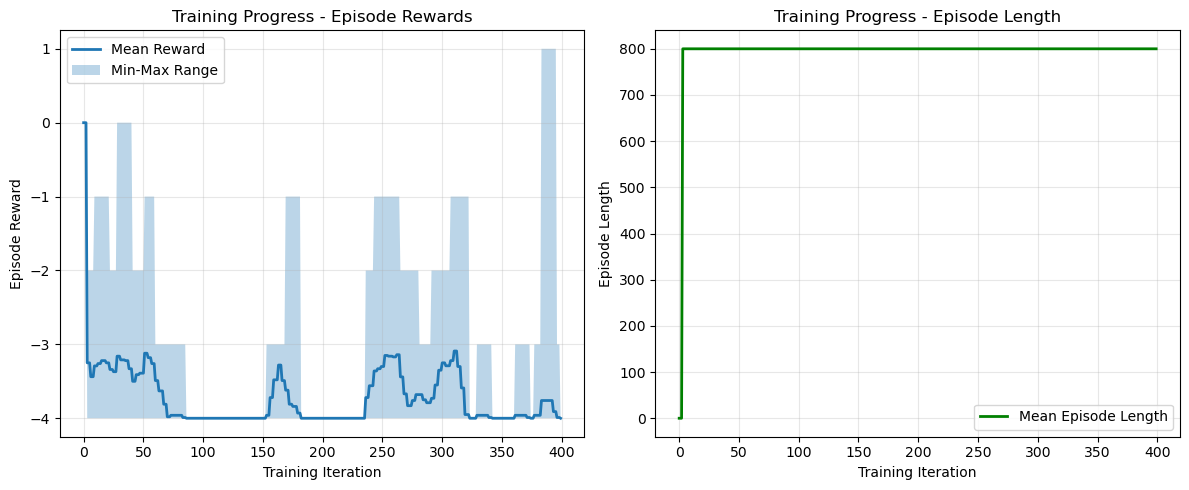


Final mean reward: -4.00
Best mean reward: 0.00
Pong theoretical max: 21 (winning 21-0)


In [74]:
%matplotlib inline

plt.figure(figsize=(12, 5))

# Plot 1: Episode rewards
plt.subplot(1, 2, 1)
plt.plot(training_history["episode_reward_mean"], label="Mean Reward", linewidth=2)
plt.fill_between(
    range(len(training_history["episode_reward_mean"])),
    training_history["episode_reward_min"],
    training_history["episode_reward_max"],
    alpha=0.3,
    label="Min-Max Range"
)
plt.xlabel("Training Iteration")
plt.ylabel("Episode Reward")
plt.title("Training Progress - Episode Rewards")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Episode length
plt.subplot(1, 2, 2)
plt.plot(training_history["episode_len_mean"], label="Mean Episode Length", color="green", linewidth=2)
plt.xlabel("Training Iteration")
plt.ylabel("Episode Length")
plt.title("Training Progress - Episode Length")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
final_mean = training_history["episode_reward_mean"][-1] if training_history["episode_reward_mean"] else 0
best_mean = max(training_history["episode_reward_mean"]) if training_history["episode_reward_mean"] else 0
print(f"\nFinal mean reward: {final_mean:.2f}")
print(f"Best mean reward: {best_mean:.2f}")
if "Pong" in GAME_ID:
    print(f"Pong theoretical max: 21 (winning 21-0)")


## Evaluation

Run evaluation episodes to see how well the trained policy performs.


In [ ]:
# Run evaluation (disabled; see manual evaluation below)
print("Skipping algo.evaluate(); use manual evaluation block below.")


ValueError: <ray.rllib.env.single_agent_env_runner.SingleAgentEnvRunner object at 0x3c0e74710> doesn't have an env! Can't call `sample()` on it.

In [ ]:
# Manual evaluation: run a few episodes and record video
import imageio
from PIL import Image, ImageDraw

def evaluate_and_record(algo, env, num_episodes=3, save_video=True):
    """Run evaluation episodes and optionally save videos."""
    # Handle inference via Algorithm (new API) or RLModule fallback
    def get_action(obs):
        # Try compute_single_action first (still available with warning)
        if hasattr(algo, "compute_single_action"):
            try:
                action_out = algo.compute_single_action(obs, explore=False)
                return (
                    action_out[0]
                    if isinstance(action_out, (list, tuple))
                    else action_out
                )
            except Exception as e:
                print(f"compute_single_action failed: {e}")
        # Fallback to RLModule forward pass
        try:
            module = algo.get_module()
            import torch
            obs_tensor = torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                out = module.forward_inference({"obs": obs_tensor})
            if "actions" in out:
                action_val = out["actions"]
            elif "action_dist_inputs" in out:
                action_val = out["action_dist_inputs"].argmax(dim=-1)
            else:
                raise ValueError("RLModule output missing actions")
            action_np = action_val.squeeze().detach().cpu().numpy()
            return int(action_np)
        except Exception as e:
            print(f"Error computing action via RLModule: {e}")
            return env.action_space.sample()
    
    all_rewards = []
    
    for ep in range(num_episodes):
        seed = PONG_SEEDS[ep % len(PONG_SEEDS)]
        obs, info = env.reset(seed=seed)
        done = False
        total_reward = 0.0
        frames = []
        
        while not done:
            # Get action from policy (works with both API stacks)
            action = get_action(obs)
            
            # Render frame
            frame = (np.clip(obs, 0, 1) * 255).astype(np.uint8).transpose(1, 2, 0)
            
            # Add action overlay
            img = Image.fromarray(frame)
            draw = ImageDraw.Draw(img)
            txt = f"action={action}, reward={total_reward:.1f}"
            draw.rectangle([0, 0, 200, 20], fill=(0, 0, 0, 200))
            draw.text((5, 3), txt, fill=(255, 255, 255))
            frame = np.array(img)
            frames.append(frame)
            
            # Step environment
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        
        all_rewards.append(total_reward)
        
        # Save video
        if save_video:
            video_path = f"rllib_eval_episode_{ep+1}.mp4"
            with imageio.get_writer(video_path, fps=30, macro_block_size=1) as writer:
                for f in frames:
                    writer.append_data(f)
            print(f"Episode {ep+1}: Reward = {total_reward:.1f}, Saved to {video_path}")
        else:
            print(f"Episode {ep+1}: Reward = {total_reward:.1f}")
    
    print(f"\nEvaluation Summary:")
    print(f"  Mean reward: {np.mean(all_rewards):.2f}")
    print(f"  Std reward: {np.std(all_rewards):.2f}")
    print(f"  Min reward: {np.min(all_rewards):.2f}")
    print(f"  Max reward: {np.max(all_rewards):.2f}")
    
    return all_rewards

# Run evaluation on a fresh helper env
eval_env = make_eval_env(PONG_SEEDS[0])
eval_rewards = evaluate_and_record(
    algo,
    eval_env,
    num_episodes=EVAL_EPISODES,
    save_video=True,
)
eval_env.close()


Game console created:
  ROM file:  /Users/lavan/miniconda3/envs/rl-pong/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -617818137
2025-11-15 22:18:11,521	WARNING deprecation.py:50 -- DeprecationWarning: `compute_single_action` has been deprecated. `Algorithm.compute_single_action` should no longer be used. Get the RLModule instance through `Algorithm.get_module([module ID])`, then compute actions through `RLModule.forward_inference({'obs': [obs batch]})`. This will raise an error in the future!


Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_

Game console created:
  ROM file:  /Users/lavan/miniconda3/envs/rl-pong/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1731038949


Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_

Game console created:
  ROM file:  /Users/lavan/miniconda3/envs/rl-pong/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1936809438


Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_

Game console created:
  ROM file:  /Users/lavan/miniconda3/envs/rl-pong/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1392079505


Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_

Game console created:
  ROM file:  /Users/lavan/miniconda3/envs/rl-pong/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1625411987


Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_policy'
Error computing action: 'SingleAgentEnvRunner' object has no attribute 'get_

## Save and Load Model

Save the trained model for later use.


In [ ]:
# Save the trained model
checkpoint_path = algo.save("./rllib_pong_checkpoint")
print(f"Model saved to: {checkpoint_path}")

# Example: Load the model later
# from ray.rllib.algorithms.ppo import PPO
# algo_loaded = PPO.from_checkpoint(checkpoint_path)
# print("Model loaded successfully")


## Notes

### Google Colab Considerations

- **GPU Runtime**: Enable GPU for faster training (Runtime > Change runtime type > GPU)
- **Resource Limits**: Configuration uses 1 worker and reduced batch sizes to fit Colab's constraints
- **Memory**: If you encounter OOM errors, reduce `train_batch_size` further
- **Ray Shutdown**: Colab may require restarting the runtime if Ray doesn't shut down cleanly

### Baseline Comparison

This notebook provides a baseline for comparing against:
- **V-JEPA2 encoder approach**: Uses pre-trained frozen encoder
- **RSSM approach**: Uses learned dynamics model

### Key Differences

- **No encoder**: Policy learns directly from raw visual observations
- **RLlib framework**: Uses well-tested RL algorithms (PPO) with built-in optimizations
- **Standard preprocessing**: 84x84 RGB frames, normalized to [0, 1]
- **Colab-optimized**: Reduced workers and batch sizes for Colab's resource constraints

### Configuration

You can adjust training parameters via environment variables:
- `NUM_TRAIN_ITERATIONS`: Number of training iterations (default: 100)
- `NUM_EVAL_EPISODES`: Number of evaluation episodes (default: 5)
- `ATARI_GAME`: Game environment (default: PongNoFrameskip-v4)

### Next Steps

- Compare training curves with V-JEPA2 and RSSM approaches
- Experiment with different RLlib algorithms (IMPALA, A3C, etc.)
- Tune hyperparameters for better performance
- Add frame stacking for temporal information


In [ ]:
# Cleanup
try:
    env.close()
except:
    pass

# Shutdown Ray (recommended for Colab to free resources)
# Note: In Colab, you may need to restart the runtime if Ray doesn't shut down cleanly
try:
    ray.shutdown()
    print("Ray shut down successfully")
except:
    print("Ray shutdown encountered an issue. You may need to restart the Colab runtime.")
